# In this tutorial we will build basic CNN for image classification.
Author :- Ankur Mali
* We will define our model and learn how to use keras module to build custom layers
* We will also design our own training loop, that is identical to model.fit in Keras.
* The aim of this excercise is to teach, how to use exisiting Tensorflow API to construct our own module and integrate it with tf.keras API.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1234)

#Things to do
* Remember to Normalize your data and create validation split from train set.
* Learn about tf.data, tf.slices and also tf.records

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_val = x_train[50000:60000]
x_train = x_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]
x_train = x_train.astype(np.float32).reshape(-1,28,28,1) / 255.0
x_val = x_val.astype(np.float32).reshape(-1,28,28,1) / 255.0
x_test = x_test.astype(np.float32).reshape(-1,28,28,1) / 255.0
y_train = tf.one_hot(y_train, depth=10)
y_val = tf.one_hot(y_val, depth=10)
y_test = tf.one_hot(y_test, depth=10)
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)
train_dataset_full = train_dataset.shuffle(buffer_size=1024).batch(len(train_dataset))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(128)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(128)
print(len(train_dataset))
print(len(test_dataset))

4431872/4422102 [==============================] - 0s 0us/step
(50000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
391
79


In [ ]:
class BatchNorm(tf.keras.layers.Layer):
    def __init__(self, dim, epsilon=10e-8, momentum=0.99):
        super(BatchNorm, self).__init__()

        self.epsilon = epsilon
        self.momentum = momentum
        self.dim = dim

        self.it_call = 0
        self.batch_size = 0

        self.mu = self.add_weight("mu", shape=[self.dim,], 
                                initializer="zeros",
                                trainable=False)
        self.var = self.add_weight("var", shape=[self.dim,], 
                                   initializer="zeros",
                                   trainable=False)

        self.gamma = self.add_weight("gamma", shape=[1, self.dim],
                                     initializer="random_normal",
                                     trainable=True)
        self.beta = self.add_weight("beta", shape=[1, self.dim],
                                    initializer="random_normal",
                                    trainable=True)
        
    
    def call(self, inputs, is_training):
        """forward
        BN(x) = gamma * ((x - mu) / sqrt(var + epsilon)) + beta
        """

        self.it_call += 1

        if is_training:   # is_training == True: compute BN 
            if self.batch_size == 0:
                self.batch_size = inputs.shape[0]
            
            batch_mu = tf.math.reduce_mean(inputs, axis=(0,1,2))
            batch_var = tf.math.reduce_variance(inputs, axis=(0,1,2))
            
            normalized_inputs = tf.math.divide((inputs - batch_mu), tf.math.sqrt(batch_var + self.epsilon))
            bn_inputs = tf.math.multiply(self.gamma, normalized_inputs) + self.beta

            # update mu and var
            if inputs.shape[0] == self.batch_size:
                running_mu = batch_mu
                running_var = batch_var
            else:
                # the last batch in training may have sample less than batch size
                running_mu = batch_mu / inputs.shape[0] * self.batch_size
                running_var = batch_var / inputs.shape[0] * self.batch_size
            
            cur_mu = running_mu * (self.momentum / self.it_call) + self.mu * (1 - (self.momentum/self.it_call))
            self.mu.assign(cur_mu)
            cur_var = running_var * (self.momentum / self.it_call) + self.var * (1 - (self.momentum/self.it_call))
            self.var.assign(cur_var)


        else: # is_training == False
            normalized_inputs = tf.math.divide((inputs - self.mu), tf.math.sqrt(self.var + self.epsilon))
            bn_inputs = tf.math.multiply(self.gamma, normalized_inputs) + self.beta
        
        return bn_inputs

# Create your custom CNN class
* Convolution layers has 4D weights of size (h,w,input_feature, output_feature), where h=height of your kernel and w = width of our kernel. If you add batches then it is 5D.
* Now your model will convolve across your input feature map with kernel and create output feature map, that is then passed to next layer.
* As we have learned in our prior class, to initialize your weights, we use tf.Variable(weight_init(size)), tf.keras.layers.Conv2D will do this for you. Play with the function and see how it works for your problem.
* Few important concepts, learn to save your model after every k epochs and start re-training from last checkpoint. This is very useful, and you don't need to retrain your model from scratch.


##Batch Norm Before RELU

In [ ]:
class ImageRecognitionCNN(tf.keras.Model):
    
    def __init__(self, num_classes, device='cpu:0', checkpoint_directory=None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation (GPU, TPU, CPU) on and the checkpoint
            directory.
            
            Args:
                num_classes: the number of labels in the network.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        ''' 
        super(ImageRecognitionCNN, self).__init__()
        
        # Initialize layers
        self.conv1 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.conv2 = tf.keras.layers.Conv2D(64, 3,padding='same', activation=None)
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv3 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.conv4 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        # self.pool2 = tf.keras.layers.MaxPool2D()
        # self.conv5 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        # self.pool2 = tf.keras.layers.MaxPool2D()
        # self.conv6 = tf.keras.layers.Conv2D(64, 3, 2, padding='same', activation=None)
        # self.conv7 = tf.keras.layers.Conv2D(64, 1, padding='same', activation=None)
        self.conv8 = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation=None)
        self.BatchNorm=BatchNorm(64)
        
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
        self.acc = tf.keras.metrics.Accuracy()


    def predict(self, images, training=True): #by default training is true
        """ Predicts the probability of each class, based on the input sample.
            
            Args:
                images: 4D tensor. Either an image or a batch of images.
                training: Boolean. Either the network is predicting in
                          training mode or not.
                         


        """
        
        x = self.conv1(images) # (128, 28, 28, 1)(batch,28,28,1) ->(128, 28, 28, 64)<class 'tensorflow.python.framework.ops.EagerTensor'>
        x=self.BatchNorm(x,training)

        # print(x.shape)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        # print(x.shape)
        # BatchNorm()(x)

        x=self.BatchNorm(x,training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv3(x)
        # BatchNorm()(x)


        x=self.BatchNorm(x,training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv4(x)

        # BatchNorm()(x)
        x=self.BatchNorm(x,training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv8(x)
        #x = tf.nn.relu(x)
        #print(x.shape)
        x = tf.reshape(x, (-1, 1, 10))
        #x = tf.keras.layers.Flatten(x)
        return x

        



    def loss_fn(self, images, target, training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(images, training)
        #print(preds.shape)
        #print(target.shape)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=preds)
        return loss


    def grads_fn(self, images, target, training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(images, target, training)
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,48,48,1)))
            dummy_pred = self.predict(dummy_input, training=training) #False
            # Restore the variables of the model
            saver = tf.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tf.Saver(self.variables).save(self.checkpoint_directory, 
                                       global_step=global_step)   
    

    def compute_accuracy_2(self, images, targets):
        """ Compute the accuracy on the input data.
        """
        with tf.device(self.device):
            
            # Predict the probability of each class
            logits = self.predict(images, training=training)#False
            # Select the class with the highest probability
            
            logits = tf.nn.softmax(logits)
            logits = tf.reshape(logits, [-1, 10])
            targets = tf.reshape(targets, [-1,10])
            preds = tf.argmax(logits, axis=1)
            goal = tf.argmax(targets, axis=1)
            self.acc.update_state(goal, preds)
            # Compute the accuracy
            result = self.acc.result().numpy()
        return result

  
    def fit_fc(self, training_data, eval_data, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the loss on the eval 
                                       dataset does not decrease after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best loss. This variable will store the lowest loss on the
        # eval dataset.
        best_loss = 999
        
        # Initialize classes to update the mean loss of train and eval
        train_loss = tf.keras.metrics.Mean('train_loss')
        eval_loss = tf.keras.metrics.Mean('eval_loss')
        acc_train = tf.keras.metrics.Mean('train_acc')
        acc_val = tf.keras.metrics.Mean('val_acc')
        
        # Initialize dictionary to store the loss history
        self.history = {}
        self.history['train_loss'] = []
        self.history['eval_loss'] = []
        self.history['train_acc'] = []
        self.history['val_acc'] = []
        
        # Begin training
        
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                #training_data_x = training_data.shuffle(buffer_size=1024).batch(128)
                for step, (images, target) in enumerate(training_data):
                    grads = self.grads_fn(images, target, training=training)#True
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Compute the loss on the training data after one epoch
                for step, (images, target) in enumerate(training_data):
                    loss = self.loss_fn(images, target, training=training) #False
                    accuracy = self.compute_accuracy_2(images,target)
                    acc_train(accuracy)
                    train_loss(loss)
                self.history['train_loss'].append(train_loss.result().numpy())
                self.history['train_acc'].append(acc_train.result().numpy())
                # Reset metrics
                train_loss.reset_states()
                acc_train.reset_states()
                
                # Compute the loss on the eval data after one epoch
                for step, (images, target) in enumerate(eval_data):
                    loss = self.loss_fn(images, target, training=training) #False
                    accuracy = self.compute_accuracy_2(images,target)
                    acc_val(accuracy)
                    eval_loss(loss)
                self.history['eval_loss'].append(eval_loss.result().numpy())
                self.history['val_acc'].append(acc_val.result().numpy())
                # Reset metrics
                eval_loss.reset_states()
                acc_val.reset_states()
                
                # Print train and eval losses
                if (i==0) | ((i+1)%verbose==0):
                    print('Train loss at epoch %d: ' %(i+1), self.history['train_loss'][-1])
                    print('Train Acc at epoch %d: ' %(i+1), self.history['train_acc'][-1])
                    
                    print('Eval loss at epoch %d: ' %(i+1), self.history['eval_loss'][-1])
                    print('Eval Acc at epoch %d: ' %(i+1), self.history['val_acc'][-1])

                # Check for early stopping
                if self.history['eval_loss'][-1]<best_loss:
                    best_loss = self.history['eval_loss'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break

In [ ]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = '/content/sample_data/model_checkpoint'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
model = ImageRecognitionCNN(num_classes=10, device=device, 
                              checkpoint_directory=checkpoint_directory)

#model = ImageRecognitionCNN(num_classes=7, device=device)

In [ ]:
# Train and Test model

acc_test = tf.keras.metrics.Mean('test_acc')

seeds = np.random.randint(12,45,3)
test_accuracy = []

for i in seeds:
  # Instantiate model. This doesn't initialize the variables yet.
  model = ImageRecognitionCNN(num_classes=10, device=device, 
                                checkpoint_directory=checkpoint_directory)
  print('Trial on random seed:',i)
  model.fit_fc(train_dataset, val_dataset, optimizer, num_epochs=20, 
            early_stopping_rounds=2, verbose=1, train_from_scratch=True)
  
  # Compute the loss on the eval data after one epoch
  for step, (images, target) in enumerate(test_dataset):
    loss = model.loss_fn(images, target, False)
    accuracy = model.compute_accuracy_2(images,target)
    acc_test(accuracy)
    test_accuracy.append(acc_test.result().numpy())

    acc_test.reset_states()

  
  # test_mean = np.mean(test_accuracy)
  # test_var = np.var(test_accuracy)

  # print(f"the mean of 3 runs is {test_mean}, and the variance is {test_var}")
  # plt.boxplot(test_accuracy)
  # plt.show()

Trial on random seed: 31
Train loss at epoch 1:  1.0975136
Train Acc at epoch 1:  0.7989086
Eval loss at epoch 1:  1.1030124
Eval Acc at epoch 1:  0.80048335
Train loss at epoch 2:  0.64961463
Train Acc at epoch 2:  0.8134409
Eval loss at epoch 2:  0.65992224
Eval Acc at epoch 2:  0.8230334
Train loss at epoch 3:  0.46760276
Train Acc at epoch 3:  0.8320499
Eval loss at epoch 3:  0.48292813
Eval Acc at epoch 3:  0.8396141
Train loss at epoch 4:  0.37645957
Train Acc at epoch 4:  0.84604394
Eval loss at epoch 4:  0.3948908
Eval Acc at epoch 4:  0.8517073
Train loss at epoch 5:  0.32155225
Train Acc at epoch 5:  0.8568461
Eval loss at epoch 5:  0.3445224
Eval Acc at epoch 5:  0.86143214
Train loss at epoch 6:  0.28820294
Train Acc at epoch 6:  0.86543995
Eval loss at epoch 6:  0.31507784
Eval Acc at epoch 6:  0.8692554
Train loss at epoch 7:  0.26136118
Train Acc at epoch 7:  0.8725977
Eval loss at epoch 7:  0.29113007
Eval Acc at epoch 7:  0.87575316
Train loss at epoch 8:  0.24640325
T

In [ ]:
test_mean = np.mean(test_accuracy)

In [ ]:
test_mean

0.9246163

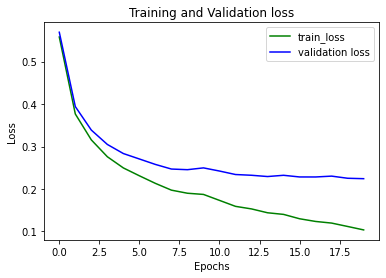

In [ ]:

loss_train = model.history['train_loss']
loss_val = model.history['eval_loss']
epochs = range(len(model.history['eval_loss']))
plt.plot(epochs, loss_train, 'g', label='train_loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##Batch norm after RELU

In [ ]:
class ImageRecognitionCNN(tf.keras.Model):
    
    def __init__(self, num_classes, device='cpu:0', checkpoint_directory=None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation (GPU, TPU, CPU) on and the checkpoint
            directory.
            
            Args:
                num_classes: the number of labels in the network.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        ''' 
        super(ImageRecognitionCNN, self).__init__()
        
        # Initialize layers
        self.conv1 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.conv2 = tf.keras.layers.Conv2D(64, 3,padding='same', activation=None)
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv3 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.conv4 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        # self.pool2 = tf.keras.layers.MaxPool2D()
        # self.conv5 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        # self.pool2 = tf.keras.layers.MaxPool2D()
        # self.conv6 = tf.keras.layers.Conv2D(64, 3, 2, padding='same', activation=None)
        # self.conv7 = tf.keras.layers.Conv2D(64, 1, padding='same', activation=None)
        self.conv8 = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation=None)
        self.BatchNorm=BatchNorm(64)
        
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
        self.acc = tf.keras.metrics.Accuracy()


    def predict(self, images, training=True): #by default training is true
        """ Predicts the probability of each class, based on the input sample.
            
            Args:
                images: 4D tensor. Either an image or a batch of images.
                training: Boolean. Either the network is predicting in
                          training mode or not.
                         


        """
        
        x = self.conv1(images) # (128, 28, 28, 1)(batch,28,28,1) ->(128, 28, 28, 64)<class 'tensorflow.python.framework.ops.EagerTensor'>
        x=self.BatchNorm(x,training)

        # print(x.shape)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        # print(x.shape)
        # BatchNorm()(x)

        
        x = tf.nn.relu(x)
        x=self.BatchNorm(x,training)
        x = self.pool1(x)
        x = self.conv3(x)
        # BatchNorm()(x)


        
        x = tf.nn.relu(x)
        x=self.BatchNorm(x,training)
        x = self.pool1(x)
        x = self.conv4(x)

        # BatchNorm()(x)
        
        x = tf.nn.relu(x)
        x=self.BatchNorm(x,training)
        x = self.pool1(x)
        x = self.conv8(x)
        #x = tf.nn.relu(x)
        #print(x.shape)
        x = tf.reshape(x, (-1, 1, 10))
        #x = tf.keras.layers.Flatten(x)
        return x

        



    def loss_fn(self, images, target, training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(images, training)
        #print(preds.shape)
        #print(target.shape)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=preds)
        return loss


    def grads_fn(self, images, target, training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(images, target, training)
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,48,48,1)))
            dummy_pred = self.predict(dummy_input, training=training) #False
            # Restore the variables of the model
            saver = tf.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tf.Saver(self.variables).save(self.checkpoint_directory, 
                                       global_step=global_step)   
    

    def compute_accuracy_2(self, images, targets):
        """ Compute the accuracy on the input data.
        """
        with tf.device(self.device):
            
            # Predict the probability of each class
            logits = self.predict(images, training=training)#False
            # Select the class with the highest probability
            
            logits = tf.nn.softmax(logits)
            logits = tf.reshape(logits, [-1, 10])
            targets = tf.reshape(targets, [-1,10])
            preds = tf.argmax(logits, axis=1)
            goal = tf.argmax(targets, axis=1)
            self.acc.update_state(goal, preds)
            # Compute the accuracy
            result = self.acc.result().numpy()
        return result

  
    def fit_fc(self, training_data, eval_data, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the loss on the eval 
                                       dataset does not decrease after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best loss. This variable will store the lowest loss on the
        # eval dataset.
        best_loss = 999
        
        # Initialize classes to update the mean loss of train and eval
        train_loss = tf.keras.metrics.Mean('train_loss')
        eval_loss = tf.keras.metrics.Mean('eval_loss')
        acc_train = tf.keras.metrics.Mean('train_acc')
        acc_val = tf.keras.metrics.Mean('val_acc')
        
        # Initialize dictionary to store the loss history
        self.history = {}
        self.history['train_loss'] = []
        self.history['eval_loss'] = []
        self.history['train_acc'] = []
        self.history['val_acc'] = []
        
        # Begin training
        
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                #training_data_x = training_data.shuffle(buffer_size=1024).batch(128)
                for step, (images, target) in enumerate(training_data):
                    grads = self.grads_fn(images, target, training=training)#True
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Compute the loss on the training data after one epoch
                for step, (images, target) in enumerate(training_data):
                    loss = self.loss_fn(images, target, training=training) #False
                    accuracy = self.compute_accuracy_2(images,target)
                    acc_train(accuracy)
                    train_loss(loss)
                self.history['train_loss'].append(train_loss.result().numpy())
                self.history['train_acc'].append(acc_train.result().numpy())
                # Reset metrics
                train_loss.reset_states()
                acc_train.reset_states()
                
                # Compute the loss on the eval data after one epoch
                for step, (images, target) in enumerate(eval_data):
                    loss = self.loss_fn(images, target, training=training) #False
                    accuracy = self.compute_accuracy_2(images,target)
                    acc_val(accuracy)
                    eval_loss(loss)
                self.history['eval_loss'].append(eval_loss.result().numpy())
                self.history['val_acc'].append(acc_val.result().numpy())
                # Reset metrics
                eval_loss.reset_states()
                acc_val.reset_states()
                
                # Print train and eval losses
                if (i==0) | ((i+1)%verbose==0):
                    print('Train loss at epoch %d: ' %(i+1), self.history['train_loss'][-1])
                    print('Train Acc at epoch %d: ' %(i+1), self.history['train_acc'][-1])
                    
                    print('Eval loss at epoch %d: ' %(i+1), self.history['eval_loss'][-1])
                    print('Eval Acc at epoch %d: ' %(i+1), self.history['val_acc'][-1])

                # Check for early stopping
                if self.history['eval_loss'][-1]<best_loss:
                    best_loss = self.history['eval_loss'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break

In [ ]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = '/content/sample_data/checkpoint'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
model = ImageRecognitionCNN(num_classes=10, device=device, 
                              checkpoint_directory=checkpoint_directory)

#model = ImageRecognitionCNN(num_classes=7, device=device)

In [ ]:
# Train and Test model

acc_test = tf.keras.metrics.Mean('test_acc')

seeds = np.random.randint(12,45,3)
test_accuracy = []

for i in seeds:
  # Instantiate model. This doesn't initialize the variables yet.
  model = ImageRecognitionCNN(num_classes=10, device=device, 
                                checkpoint_directory=checkpoint_directory)
  print('Trial on random seed:',i)
  model.fit_fc(train_dataset, val_dataset, optimizer, num_epochs=20, 
            early_stopping_rounds=2, verbose=1, train_from_scratch=True)
  
  # Compute the loss on the eval data after one epoch
  for step, (images, target) in enumerate(test_dataset):
    loss = model.loss_fn(images, target, False)
    accuracy = model.compute_accuracy_2(images,target)
    acc_test(accuracy)
    test_accuracy.append(acc_test.result().numpy())

    acc_test.reset_states()

  
  # test_mean = np.mean(test_accuracy)
  # test_var = np.var(test_accuracy)

  # print(f"the mean of 3 runs is {test_mean}, and the variance is {test_var}")
  # plt.boxplot(test_accuracy)
  # plt.show()

Trial on random seed: 31
Train loss at epoch 1:  1.2230809
Train Acc at epoch 1:  0.8063138
Eval loss at epoch 1:  1.2255476
Eval Acc at epoch 1:  0.8075143
Train loss at epoch 2:  0.65839
Train Acc at epoch 2:  0.8208721
Eval loss at epoch 2:  0.6654389
Eval Acc at epoch 2:  0.83127856
Train loss at epoch 3:  0.44223884
Train Acc at epoch 3:  0.84056425
Eval loss at epoch 3:  0.45429483
Eval Acc at epoch 3:  0.8483261
Train loss at epoch 4:  0.35298556
Train Acc at epoch 4:  0.8548719
Eval loss at epoch 4:  0.3724994
Eval Acc at epoch 4:  0.8603368
Train loss at epoch 5:  0.30312565
Train Acc at epoch 5:  0.8650367
Eval loss at epoch 5:  0.32956183
Eval Acc at epoch 5:  0.8692994
Train loss at epoch 6:  0.27012184
Train Acc at epoch 6:  0.8730123
Eval loss at epoch 6:  0.30338943
Eval Acc at epoch 6:  0.8765162
Train loss at epoch 7:  0.25107968
Train Acc at epoch 7:  0.8792588
Eval loss at epoch 7:  0.2890604
Eval Acc at epoch 7:  0.88202834
Train loss at epoch 8:  0.2312391
Train Ac

In [ ]:
test_mean = np.mean(test_accuracy)
test_mean

0.92041403

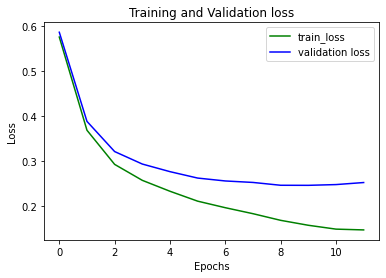

In [ ]:
loss_train = model.history['train_loss']
loss_val = model.history['eval_loss']
epochs = range(len(model.history['eval_loss']))
plt.plot(epochs, loss_train, 'g', label='train_loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()